<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/multimodal/vcoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/SHI-Labs/VCoder.git
%cd /content/VCoder
!pip install -e .
!pip install ninja
!pip install flash-attn --no-build-isolation

In [2]:
!pip install -q transformers==4.31.0

In [ ]:
%cd /content/VCoder
!CUDA_VISIBLE_DEVICES=0 python -m vcoder_llava.serve.cli \
    --model-path shi-labs/vcoder_ds_llava-v1.5-13b \
    --image-file "/content/a_suits.jpeg" \
    --seg-file "/content/a_suits_pano.png" \
    --depth-file "/content/a_suits_depth.png" \
    --device "auto" \
    --load-4bit

In [ ]:
# cpu: 3.3, gpu: 10.0GB

Depth Estimation

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git

In [ ]:
from transformers import AutoImageProcessor, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests
import matplotlib


def render_depth(values, colormap_name="magma_r") -> Image:
    min_value, max_value = values.min(), values.max()
    normalized_values = (values - min_value) / (max_value - min_value)

    colormap = matplotlib.colormaps[colormap_name]
    colors = colormap(normalized_values, bytes=True) # ((1)xhxwx4)
    colors = colors[:, :, :3] # Discard alpha component
    return Image.fromarray(colors)

device = "cuda" if torch.cuda.is_available() else "cpu"
image_processor = AutoImageProcessor.from_pretrained("facebook/dpt-dinov2-base-nyu")
model = DPTForDepthEstimation.from_pretrained("facebook/dpt-dinov2-base-nyu").to(device)

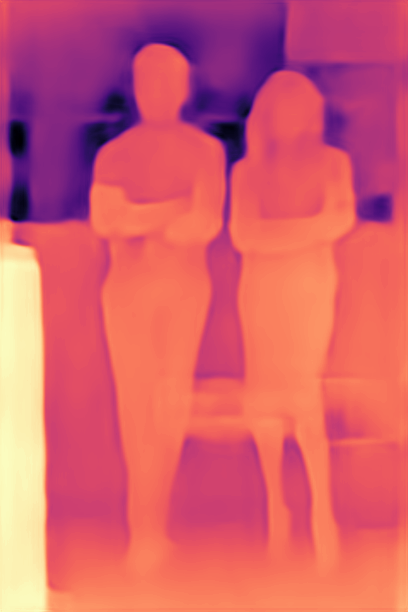

In [4]:
image = Image.open("/content/a_suits.jpeg")

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

depth_image = render_depth(formatted)
display(depth_image)

Oneformer

In [ ]:
from transformers import AutoModelForUniversalSegmentation, AutoProcessor
import torch
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "shi-labs/oneformer_ade20k_swin_large"
seg_model = AutoModelForUniversalSegmentation.from_pretrained(model_id).to(device)
seg_processor = AutoProcessor.from_pretrained(model_id)

In [ ]:
import requests
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

panoptic_inputs = seg_processor(images=image, task_inputs=["panoptic"], return_tensors="pt").to(device)
# forward pass
with torch.no_grad():
  outputs = seg_model(**panoptic_inputs)

panoptic_segmentation = seg_processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]